In [1]:
# plot loss function from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# converting MNIST into 3 dimentional from Rabia Yasa Kostas (1700421)/
# loading data office-31 from Lyu Chaofan 1706987 from LYU CHAOFAN_Github(permission was obtained)https://github.com/C-002/CE888_Assignment/blob/master/LoadImages.ipynb
from timeit import default_timer as timer
import numpy as np
import pandas as pd
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
import os
import cv2
import matplotlib.pyplot as plt
from dataSet import dataSet

Using TensorFlow backend.


In [2]:
#randomforest classifier
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
#prediction 
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 31

# use just a small sample of the train set to test
SAMPLE_SIZE = 500
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 15
# how many times we will loop over ask()/tell()
GENERATIONS = 50

In [3]:
#Loading the data from path-
# This part adopted from LYU CHAOFAN_Github(permission was obtained)https://github.com/C-002/CE888_Assignment/blob/master/LoadImages.ipynb
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'
paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1
# print (labels)
images_path = []
Amazon = dataSet()
webcam = dataSet()

In [4]:
#loading Amazon data
for dirname in files:
    images_name = os.listdir(Amazon_path + '/' + dirname)
    for name in images_name:
        Image_Path = Amazon_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        Amazon.upData(image_data, labels[dirname], labels)
Amazon.sHape()
#loading webcam data
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)
webcam.sHape()



done

done


In [5]:
#label classifier data
x_train = Amazon.data
y_train = Amazon.label
x_test  = webcam.data
y_test  = webcam.label
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)
#data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#domain classifier data
x_domain=np.concatenate((x_train,x_test), axis =0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis=0)
print("For label classifier")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("For domain classifier")
print('x_domain shape:', x_domain.shape)
print(y_domain.shape[0], 'domain samples')

For label classifier
x_train shape: (2817, 28, 28, 3)
x_test shape: (795, 28, 28, 3)
2817 train samples
795 test samples
For domain classifier
x_domain shape: (3612, 28, 28, 3)
3612 domain samples


In [6]:
#the neural network model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(80, activation='relu'))
nnw = NNWeightHelper(model)
weights = nnw.get_weights()


In [7]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print('x_test shape:',y_test.shape)
print('x_pred shape:',y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)

Total number of weights to evolve is: (756752,)
x_test shape: (795,)
x_pred shape: (795,)
Non-trained NN Test accuracy: 0.04150943396226415


In [8]:
#evolutionary process with SNES
snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        y_pred2 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score2 = accuracy_score(y_domain[subsample_indices_valid], y_pred)
                    
        # append to array of values that are to be returned
        total=score+score2
        told.append(total)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy on target:', test_accuracy)

Step 1.0 : 0.42714570858283435 best: 0.42714570858283435 15
It took 35.595348029979505 seconds to complete generation 1
Step 2.0 : 0.3992015968063872 best: 0.42714570858283435 15
It took 32.98077584395651 seconds to complete generation 2
Step 3.0 : 0.4231536926147704 best: 0.42714570858283435 15
It took 34.33455558796413 seconds to complete generation 3
Step 4.0 : 0.43313373253493015 best: 0.43313373253493015 15
It took 35.585456529050134 seconds to complete generation 4
Step 5.0 : 0.4191616766467066 best: 0.43313373253493015 15
It took 40.206820635008626 seconds to complete generation 5
Step 6.0 : 0.4091816367265469 best: 0.43313373253493015 15
It took 46.891713293036446 seconds to complete generation 6
Step 7.0 : 0.4031936127744511 best: 0.43313373253493015 15
It took 38.895303704892285 seconds to complete generation 7
Step 8.0 : 0.39520958083832336 best: 0.43313373253493015 15
It took 46.607879234012216 seconds to complete generation 8
Step 9.0 : 0.3852295409181637 best: 0.433133732

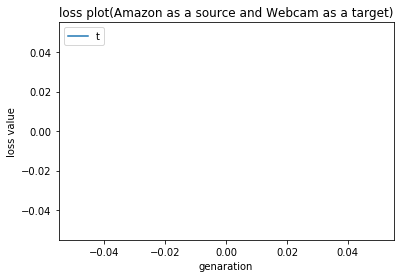

In [9]:
plt.plot(log)
plt.title('loss plot(Amazon as a source and Webcam as a target)')
plt.xlabel('genaration')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.savefig('Plot_amazon_webcam.png')
plt.show()